In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [25]:
df = pd.read_csv('data/BA_reviews.csv')

In [26]:
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | Starting off at Heathrow Te...
1,1,Not Verified | We have flown this route with ...
2,2,✅ Trip Verified | A last minute business trip ...
3,3,✅ Trip Verified | Overall I would say disapp...
4,4,Not Verified | LHR to Delhi in Business. Exce...


In [27]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [28]:
df.head()

,reviews
0,✅ Trip Verified | Starting off at Heathrow Te...
1,Not Verified | We have flown this route with ...
2,✅ Trip Verified | A last minute business trip ...
3,✅ Trip Verified | Overall I would say disapp...
4,Not Verified | LHR to Delhi in Business. Exce...


In [29]:
# Compile regular expressions for better performance
ba_regex = re.compile(r'\bBA\b', re.IGNORECASE)
british_airway_regex = re.compile(r'\bbritish\s+airway?\b', re.IGNORECASE)
british_airways_regex = re.compile(r'\bbritish\s+airways?\b', re.IGNORECASE)
flight_regex = re.compile(r'\bflight\b', re.IGNORECASE)

def clean_review(review):
    # Check if the review starts with "✅ Trip Verified"
    if review.startswith("✅ Trip Verified"):
        review_status = "verified"
        # Remove the "✅ Trip Verified" prefix
        review_text = review[len("✅ Trip Verified") + 1:].strip()
    else:
        review_status = "not verified"
        # Remove the "Not Verified" prefix
        review_text = review[len("Not Verified") + 1:].strip()
        
    # Remove special characters, emojis, and unwanted symbols
    review_text = re.sub(r'[^\w\s]', ' ', review_text)
    
    # Remove the word 'BA' (Short for British Airways)
    review_text = ba_regex.sub('', review_text)

    # Remove the word 'british airways' (for British Airways)
    review_text = british_airways_regex.sub('', review_text)

    # Remove the word 'british airway' (for British Airways)
    review_text = british_airway_regex.sub('', review_text)

    # Remove the word 'flight'
    review_text = flight_regex.sub('', review_text)
    
    # Remove extra whitespaces
    review_text = re.sub(r'\s+', ' ', review_text)
    
    # Convert to lowercase
    review_text = review_text.lower().strip()
    
    return review_status, review_text

# Apply the cleaning function to the 'reviews' column
df['review_status'], df['cleaned_reviews'] = zip(*df['reviews'].apply(clean_review))


In [30]:
df.head()

,reviews,review_status,cleaned_reviews
0,✅ Trip Verified | Starting off at Heathrow Te...,verified,starting off at heathrow terminal 3 check in w...
1,Not Verified | We have flown this route with ...,not verified,we have flown this route with easyjet regularl...
2,✅ Trip Verified | A last minute business trip ...,verified,a last minute business trip to hnd a route i r...
3,✅ Trip Verified | Overall I would say disapp...,verified,overall i would say disappointing due to statu...
4,Not Verified | LHR to Delhi in Business. Exce...,not verified,lhr to delhi in business exceptional stylish a...


In [31]:
df.drop(columns=['reviews'], inplace=True)

In [32]:
data = df.copy()

data.head()

,review_status,cleaned_reviews
0,verified,starting off at heathrow terminal 3 check in w...
1,not verified,we have flown this route with easyjet regularl...
2,verified,a last minute business trip to hnd a route i r...
3,verified,overall i would say disappointing due to statu...
4,not verified,lhr to delhi in business exceptional stylish a...


First, let us perform topic modelling, sentiment analysis and word cloud analysis on all reviews (verified and not verified)

Topics found via LDA:
Topic 1:
['london', 'airline', 'food', 'economy', 'service', 'good', 'business', 'class', 'seats', 'seat']
Topic 2:
['day', 'time', 'booked', 'cancelled', 'airport', 'told', 'london', 'service', 'customer', 'hours']
Topic 3:
['meal', 'seat', 'london', 'food', 'business', 'staff', 'class', 'service', 'cabin', 'crew']
Topic 4:
['economy', 'seats', 'cabin', 'club', 'food', 'good', 'business', 'service', 'class', 'seat']
Topic 5:
['service', 'london', 'seats', 'lounge', 'food', 'crew', 'boarding', 'check', 'good', 'time']

Sentiment Analysis of Reviews:
Total Reviews: 1000
Positive Reviews: 631 (63.10%)
Negative Reviews: 360 (36.00%)
Neutral Reviews: 9 (0.90%)


Overall Sentiment score is 0.07 - meaning sentiment is positive


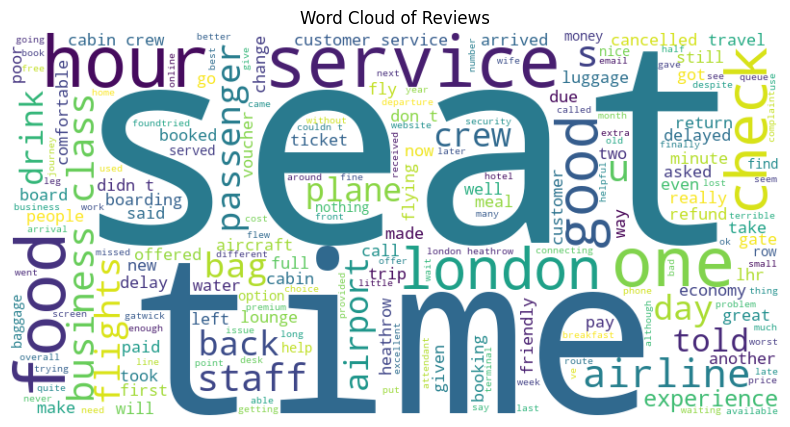

In [33]:
def review_analyzer(df):

    # Perform topic modeling
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['cleaned_reviews'])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    # Print topics
    print("Topics found via LDA:")
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx+1}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

    # Perform sentiment analysis
    sentiment_scores = df['cleaned_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Calculate the percentage of positive, negative, and neutral reviews
    total_reviews = len(sentiment_scores)
    positive_reviews = sum(1 for score in sentiment_scores if score > 0)
    negative_reviews = sum(1 for score in sentiment_scores if score < 0)
    neutral_reviews = sum(1 for score in sentiment_scores if score == 0)

    percent_positive = (positive_reviews / total_reviews) * 100
    percent_negative = (negative_reviews / total_reviews) * 100
    percent_neutral = (neutral_reviews / total_reviews) * 100

    # Print the analysis results
    print("\nSentiment Analysis of Reviews:")
    print(f"Total Reviews: {total_reviews}")
    print(f"Positive Reviews: {positive_reviews} ({percent_positive:.2f}%)")
    print(f"Negative Reviews: {negative_reviews} ({percent_negative:.2f}%)")
    print(f"Neutral Reviews: {neutral_reviews} ({percent_neutral:.2f}%)\n")


    # Calculate overall sentiment score
    print(f'\nOverall Sentiment score is {sentiment_scores.mean():.2f} - meaning sentiment is {"positive" if sentiment_scores.mean() > 0 else "neutral" if sentiment_scores.mean() == 0 else "negative"}')


    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_reviews']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Reviews')
    plt.show()


review_analyzer(df)

### Analysis on Verified Reviews

Topics found via LDA:
Topic 1:
['check', 'refund', 'staff', 'class', 'business', 'london', 'customer', 'told', 'hours', 'service']
Topic 2:
['did', 'hours', 'heathrow', 'cancelled', 'london', 'airport', 'time', 'customer', 'airline', 'service']
Topic 3:
['time', 'seats', 'business', 'cabin', 'service', 'class', 'crew', 'seat', 'food', 'good']
Topic 4:
['food', 'hours', 'really', 'cabin', 'seats', 'plane', 'good', 'boarding', 'crew', 'time']
Topic 5:
['airport', 'staff', 'bag', 'service', 'said', 'heathrow', 'check', 'luggage', 'did', 'london']

Sentiment Analysis of Reviews:
Total Reviews: 761
Positive Reviews: 482 (63.34%)
Negative Reviews: 272 (35.74%)
Neutral Reviews: 7 (0.92%)


Overall Sentiment score is 0.07 - meaning sentiment is positive


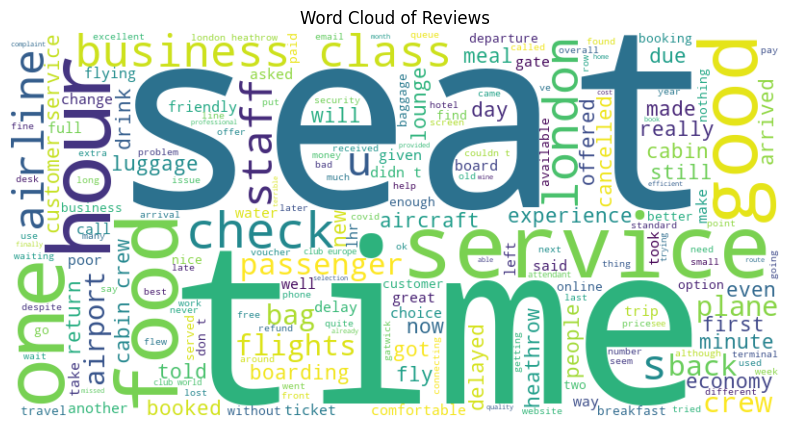

In [34]:
review_analyzer(df[df.review_status == "verified"])


### Analysis on Non-Verified Reviews

Topics found via LDA:
Topic 1:
['said', 'crew', 'customer', 'staff', 'london', 'hours', 'just', 'got', 'service', 'told']
Topic 2:
['ticket', 'class', 'hours', 'booked', 'check', 'time', 'pay', 'staff', 'business', 'service']
Topic 3:
['london', 'did', 'check', 'staff', 'hours', 'airport', 'time', 'bags', 'bag', 'luggage']
Topic 4:
['booked', 'return', 'cancelled', 'refund', 'hours', 'airline', 'travel', 'service', 'customer', 'flights']
Topic 5:
['business', 'crew', 'economy', 'london', 'time', 'seat', 'good', 'seats', 'food', 'service']

Sentiment Analysis of Reviews:
Total Reviews: 239
Positive Reviews: 149 (62.34%)
Negative Reviews: 88 (36.82%)
Neutral Reviews: 2 (0.84%)


Overall Sentiment score is 0.05 - meaning sentiment is positive


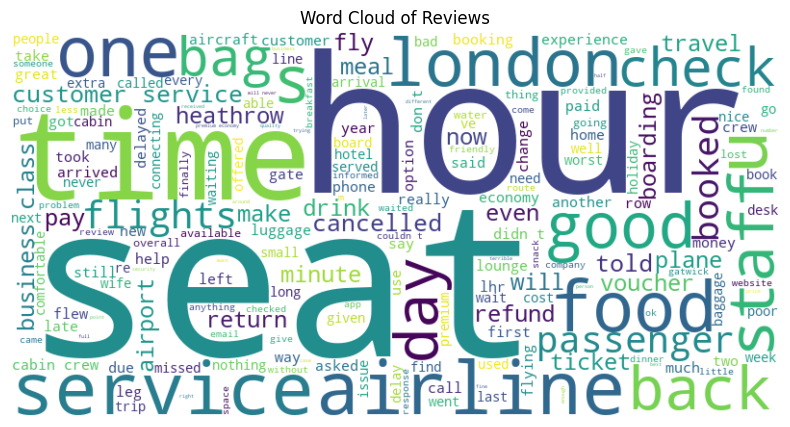

In [35]:
review_analyzer(df[df.review_status == "not verified"])